In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime
import os
from skimage.transform import resize
import random
from tensorflow.python.keras.utils.data_utils import Sequence
from scipy.ndimage import zoom
from scipy.ndimage import shift
from skimage.transform import rotate
from sklearn import metrics

In [2]:
#input variables
target_path = "C:\\Users\\awe2\\DL_DES-master\\data\\sdss-galaxyzoo\\high_certainty\\sdss_metadata\\"

#path = 'image_arrays_new_new\\'
#validation_path = path + 'validation'
#training_path = path + 'training'
#test_path = path + 'test'

#model variables
batch_size = 32 #
epoch_number = 10 #when ready to test, set to 25
learning_rate = 1e-4
train_from_file = True #load weights from an old model, add noise, then train more
np.random.seed(1)

if train_from_file == True:
    learning_rate = 1e-5 #lets try this
    
params_train = {'dim': (120,120),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 6,
          'shuffle': True}

params_test = {'dim': (120,120),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 6,
          'shuffle': False}


#more parameters means more prone to overfitting, and I am 5/3 times worse on parameters compared to the paper I have
#based this on. (5 bands instead of 3) I need to find ways to add more regularization, or otherwise might try reducing my number
#of layers to reduce the number of parameters.

In [3]:
#https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions/48097478
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [4]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):

    def __init__(self, list_IDs, labels, batch_size=32, dim=(120,120), n_channels=3,
                 n_classes=2, shuffle=True):
     #   'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
    #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
    #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
    

      # Generate data and perform augmentation
        for i, ID in enumerate(list_IDs_temp):
            
          # Store sample
            if ID[:2] == 'HP':
                X[i,:,:,0:5] = np.load('HP_inputs/' + ID + '.npy')
            if ID[:2] == 'LP':
                X[i,:,:,0:5] = np.load('LP_inputs/' + ID + '.npy')
            if ID[:2] == 'MP':
                X[i,:,:,0:5] = np.load('MP_inputs/' + ID + '.npy')
            
            #I messed up when generating my inputs on the order of the band; I want to train the model in the usual bands:
            
            #u_filter = X[i,:,:,0]
            #g_filter = X[i,:,:,1]
            i_filter = X[i,:,:,2]
            r_filter = X[i,:,:,3]
            #z_filter = X[i,:,:,4]

            #X[i,:,:,0] = u_filter
            #X[i,:,:,1] = g_filter
            X[i,:,:,2] = r_filter
            X[i,:,:,3] = i_filter
            #X[i,:,:,4] = z_filter              
            #flip
            if random.random() > 0.5:
                X[i,:,:,0:5] = np.flip(X[i,:,:,0:5],0)
            if random.random() > 0.5:
                X[i,:,:,0:5] = np.flip(X[i,:,:,0:5],1)
            
            #shift
            if random.random() > 0.5 :
                X[i,:,:,0:5] = shift(X[i,:,:,0:5], (4,0,0), mode='nearest')
            elif random.random() > 0.5 :
                X[i,:,:,0:5] = shift(X[i,:,:,0:5], (-4,0,0), mode='nearest')
                              
            if random.random() > 0.5 :
                X[i,:,:,0:5] = shift(X[i,:,:,0:5], (0,4,0), mode='nearest')
            elif random.random() > 0.5 :
                X[i,:,:,0:5] = shift(X[i,:,:,0:5], (0,-4,0), mode='nearest')
          
            #zoom in/out
            zoom_factor = random.uniform(0.75,1.3)
            X[i,:,:,0:5] = clipped_zoom(X[i,:,:,0:5],zoom_factor)
            
            #rotate
            angle = 45*random.random()
            X[i,:,:,0:5] = rotate(X[i,:,:,0:5], angle=angle, mode='reflect')
            
            #Load Magnitude array and place in 6th channel
            string = ID.split('_') #list looks like ['HP','00000']
            string = string[0] + '_Mag_' + string[1] +'.npy'
            if ID[:2] == 'HP':
                X[i,:,:,5] = np.load('HP_Magnitudes\\'+string)
            if ID[:2] == 'LP':
                X[i,:,:,5] = np.load('LP_Magnitudes\\'+string)
            if ID[:2] == 'MP':
                X[i,:,:,5] = np.load('MP_Magnitudes\\'+string)
            # Store class
            y[i] = self.labels[ID]
    
        if self.n_classes > 2:
            return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        else:
            return X, y

    def __len__(self):
    #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
    #  'Generate one batch of data'
      # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

      # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [5]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class LP_DataGenerator(Sequence):

    def __init__(self, list_IDs, labels, batch_size=32, dim=(120,120), n_channels=3,
                 n_classes=2, shuffle=False):
     #   'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
    #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
    #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
    

      # Generate data and perform augmentation
        for i, ID in enumerate(list_IDs_temp):
            
          # Store sample
            X[i,:,:,0:5] = np.load('LP_inputs/' + ID + '.npy')
                        
            #flip
            if random.random() > 0.5:
                X[i,:,:,0:5] = np.flip(X[i,:,:,0:5],0)
            if random.random() > 0.5:
                X[i,:,:,0:5] = np.flip(X[i,:,:,0:5],1)
            
            #shift
            if random.random() > 0.5 :
                X[i,:,:,0:5] = shift(X[i,:,:,0:5], (4,0,0), mode='nearest')
            elif random.random() > 0.5 :
                X[i,:,:,0:5] = shift(X[i,:,:,0:5], (-4,0,0), mode='nearest')
                              
            if random.random() > 0.5 :
                X[i,:,:,0:5] = shift(X[i,:,:,0:5], (0,4,0), mode='nearest')
            elif random.random() > 0.5 :
                X[i,:,:,0:5] = shift(X[i,:,:,0:5], (0,-4,0), mode='nearest')
          
            #zoom in/out
            zoom_factor = random.uniform(0.75,1.3)
            X[i,:,:,0:5] = clipped_zoom(X[i,:,:,0:5],zoom_factor)
            
            #rotate
            angle = 45*random.random()
            X[i,:,:,0:5] = rotate(X[i,:,:,0:5], angle=angle, mode='reflect')
            
            #Load Magnitude array and place in 6th channel
            string = ID.split('_') #list looks like ['LP','00000']
            string = string[0] + '_Mag_' + string[1] +'.npy'
            X[i,:,:,5] = np.load('LP_Magnitudes\\'+string)
            
            # Store class
            y[i] = self.labels[ID]
    
        if self.n_classes > 2:
            return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        else:
            return X, y

    def __len__(self):
    #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
    #  'Generate one batch of data'
      # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

      # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [6]:
#generate the targets.
a = []
for file in (os.listdir(target_path)):
    target = pd.read_csv(target_path+file,usecols=[14])
    a.append((target["target"].values))
targets = np.concatenate([a[0],a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8]])

In [7]:
#generate the LP test targets
b = []
for file in os.listdir("C:\\Users\\awe2\\try_this\\NEW_METADATA\\LOW_CERTAINTY\\"):
    if file.endswith('.csv'):
        target = pd.read_csv("C:\\Users\\awe2\\try_this\\NEW_METADATA\\LOW_CERTAINTY\\" + file, usecols=[13])
        b.append((target["Spiral"].values))
LP_targets = np.concatenate([b[0],b[1]])

In [8]:
#generate the MP test targets
c = []
for file in os.listdir("C:\\Users\\awe2\\try_this\\NEW_METADATA\\MID_CERTAINTY\\"):
    if file.endswith('.csv'):
        target = pd.read_csv("C:\\Users\\awe2\\try_this\\NEW_METADATA\\MID_CERTAINTY\\" + file, usecols=[14])
        c.append((target["target"].values))
MP_targets = np.concatenate([c[0],c[1],c[2],c[3],c[4],c[5],c[6],c[7],c[8],c[9],c[10],c[11],c[12],c[13]])

In [9]:
#targets each correspond to an array called: HP_*****.npy in folder HP_inputs// where ***** is zfilled starting at 00000
#we can use os.listdir to generate strings of the correct iterator

#we then need to sort out where each of these files will go.
#for i,file in enumerate(os.listdir("HP_inputs"))

"""
labels = {}
for i in range(len(targets)):
    string = "HP_{}.npy".format(str(i).zfill(5))
    #if string in os.listdir("HP_inputs"):
    name = "HP_{}".format(str(i).zfill(5))
    labels.update({name:targets[i]})
        
f = open("HP_inputs\\labels.txt","w")
f.write( str(labels) )
f.close()
"""
with open("labels.txt","r") as inf:
    labels = eval(inf.read())

In [10]:
#Load the target coding for LP
"""
LP_labels = {}
for i in range(len(LP_targets)):
    string = "LP_{}.npy".format(str(i).zfill(5))
    #if string in os.listdir("LP_inputs"):
    name = "LP_{}".format(str(i).zfill(5))
    LP_labels.update({name:LP_targets[i]})
        
f = open("LP_labels.txt","w")
f.write( str(LP_labels) )
f.close()
"""
with open("LP_labels.txt","r") as inf:
    LP_labels = eval(inf.read())

In [11]:
#Load the target coding for MP
"""
MP_labels = {}
for i in range(len(MP_targets)):
    string = "MP_{}.npy".format(str(i).zfill(5))
    #if string in os.listdir("MP_inputs"):
    name = "MP_{}".format(str(i).zfill(5))
    MP_labels.update({name:MP_targets[i]})
        
f = open("MP_labels.txt","w")
f.write( str(MP_labels) )
f.close()
"""

with open('MP_labels.txt.','r') as inf:
    MP_labels = eval(inf.read())

In [12]:
#now we shuffle our data list, and partition into train, test, and validation sets.
data_list = os.listdir("HP_inputs")
random.shuffle(data_list)
#we want 20% of the data reserved for testing, and then another 15% reserved for validation.
top_index = len(data_list)
first_index = int(round(top_index * 0.65))
second_index = int(round(top_index * 0.15)) + first_index

train_list = data_list[0:first_index]
val_list = data_list[first_index:second_index]
test_list = data_list[second_index::]

for i,file in enumerate(train_list):
    train_list[i] = file.split('.')[0]
for i,file in enumerate(val_list):
    val_list[i] = file.split('.')[0]
for i,file in enumerate(test_list):
    test_list[i] = file.split('.')[0]


In [13]:
#now for the LP inputs
LP_data_list = os.listdir("LP_inputs")
random.shuffle(LP_data_list)

for i,file in enumerate(LP_data_list):
    LP_data_list[i] = file.split('.')[0]

In [14]:
#now for the MP inputs
MP_data_list = os.listdir("MP_inputs")
random.shuffle(MP_data_list)

for i,file in enumerate(MP_data_list):
    MP_data_list[i] = file.split('.')[0]

In [15]:
for i in range(len(MP_data_list)):
    MP_labels[MP_data_list[i]]

In [16]:
#now we want to 'mix' the following array of LP names into the HP train, and move them out of the LP test.

#we want to do this before we call up our partitions. 

#we will need to add the LP labels to labels of the LP in mixarray
    #should be able just to join the two, labels and LP_labels, since its what is in partition that matters.
mix_array = np.load('mix_list.npy')
for i in mix_array:
    #first delete the names from LP_data_list
    LP_data_list.remove(i)
    #now append the names to train list
    train_list.append(i)
#and then merge the LP_labels into labels
"""
#now mix MP into
mix_array = np.load('mix_list_MP_new.npy')
for i in mix_array:
    #first delete the names from LP_data_list
    MP_data_list.remove(i)
    #now append the names to train list
    train_list.append(i)
#and then merge the LP_labels into labels
labels.update(MP_labels)
"""

"\n#now mix MP into\nmix_array = np.load('mix_list_MP_new.npy')\nfor i in mix_array:\n    #first delete the names from LP_data_list\n    MP_data_list.remove(i)\n    #now append the names to train list\n    train_list.append(i)\n#and then merge the LP_labels into labels\nlabels.update(MP_labels)\n"

In [17]:
labels.update(LP_labels)
labels.update(MP_labels)

In [18]:
#ensure class balance:
num_spirals  = 0
num_ellipticals = 0

for i in range(len(train_list)):
    if labels[train_list[i]] == 1:
        num_spirals+=1
    if labels[train_list[i]] == 0:
        num_ellipticals+=1

if (0.45 < num_spirals/(num_spirals + num_ellipticals) < 0.55) == False:
    raise Exception('class imbalance, try reshuffling')

In [19]:
partition = {'train':train_list,'validation':val_list,'test':test_list}
LP_partition = {'test':LP_data_list}
MP_partition = {'test':MP_data_list}

In [20]:
LP_test_generator = LP_DataGenerator(LP_partition['test'], labels, **params_test)
MP_test_generator = DataGenerator(MP_partition['test'], labels, **params_test)
training_generator = DataGenerator(partition['train'], labels, **params_train)
validation_generator = DataGenerator(partition['validation'], labels, **params_test)
test_generator = DataGenerator(partition['test'], labels, **params_test)

In [21]:
#so this is pretty neat, you can create a keras callback to display on tensorboard using a simplified summary tf api

#and also this is an example of how to change the lr on the fly, which is pretty handy
#https://keras.io/callbacks/


"""
    file_writer = tf.summary.create_file_writer(logdir + "/metrics")
    file_writer.set_as_default()
"""
def lr_schedule(epoch,lr):

#Returns a custom learning rate that decreases as epochs progress.
    if epoch > 1:
        lr = 1e-4
    if epoch > 7:
        lr = 1e-5
    if epoch > 12:
        lr = 1e-6
    if epoch > 20:
        lr = 5e-6

    tf.summary.scalar('learning_rate', tensor=lr)
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

#logdir="summaries/scalars/" + str(datetime.datetime.now().timestamp())
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
#                                                   histogram_freq=1,
#                                                   write_graph=False,
#                                                   write_grads=True,)
#                                                   #write_images=True)
#will it still print stuff

In [22]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    keras.backend.get_session().run(tf.local_variables_initializer())
    return auc

In [23]:
def create_model(learning_rate=learning_rate):
    
    model = keras.Sequential([])
    
    model.add(keras.layers.Conv2D(input_shape=(120,120,6),filters=32,kernel_size=6,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.5))
    
    model.add(keras.layers.Conv2D(filters=64,kernel_size=5,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=2,))
    model.add(keras.layers.Dropout(rate=0.25)) #best = 0.25
    
    model.add(keras.layers.Conv2D(filters=128,kernel_size=2,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=2,))
    model.add(keras.layers.Dropout(rate=0.25)) #best = 0.25
    
    model.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.35)) #best = 0.35

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=128,activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(units=64,activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(units=1,activation=tf.nn.sigmoid)) #tf.nn.softmax for categorical, sigmoid for binary
    
    adam = keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy',auc]) 
    return(model)

In [24]:
steps_to_take = int(len(train_list)/batch_size)
val_steps_to_take = int(len(val_list)/batch_size)
test_steps_to_take = int(len(test_list)/batch_size)
LP_test_steps_to_take = int(len(LP_data_list)/batch_size)
MP_test_steps_to_take = int(len(MP_data_list)/batch_size)
                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.

print(steps_to_take)
print(val_steps_to_take)
print(test_steps_to_take)
print(LP_test_steps_to_take)
print(MP_test_steps_to_take)

815
181
241
241
2098


In [25]:
filepath = "models//6-band-CNN_10_10.hdf5"
#ModelCheckpointCB = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
ModelCheckpointCB = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [26]:
keras.backend.clear_session()
model = create_model(learning_rate = learning_rate)
if train_from_file == True:
    model.load_weights("models//6-band-CNN_10_6.hdf5")
    weights = model.get_weights()
    for i in range(len(weights)):
        weights[i] = weights[i] + np.random.normal(0,np.std(weights[i]),np.shape(weights[i]))
    model.set_weights(weights) #okay now I have set the weights from the previous model, plus some small gaussian noise

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [27]:
#another callback
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-8, verbose=1, mode='min')

In [28]:
hist = model.fit_generator(generator=training_generator,
                    steps_per_epoch=steps_to_take, 
                    epochs=18,
                    validation_data=validation_generator,
                    validation_steps=val_steps_to_take,
                    initial_epoch=7,
                    verbose=1,
                    callbacks=[ModelCheckpointCB,lr_callback])

Instructions for updating:
Use tf.cast instead.


C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Epoch 8/18
181/181 [==============================] - 818s 5s/step - loss: 0.3135 - acc: 0.8831 - auc: 0.8417

Epoch 00008: val_loss improved from inf to 0.31348, saving model to models//6-band-CNN_10_10.hdf5
815/815 [==============================] - 4480s 5s/step - loss: 0.5669 - acc: 0.7603 - auc: 0.7217 - val_loss: 0.3135 - val_acc: 0.8831 - val_auc: 0.8417
Epoch 9/18
181/181 [==============================] - 757s 4s/step - loss: 0.2790 - acc: 0.8757 - auc: 0.8982

Epoch 00009: val_loss improved from 0.31348 to 0.27902, saving model to models//6-band-CNN_10_10.hdf5
815/815 [==============================] - 4218s 5s/step - loss: 0.3310 - acc: 0.8709 - auc: 0.8793 - val_loss: 0.2790 - val_acc: 0.8757 - val_auc: 0.8982
Epoch 10/18
181/181 [==============================] - 512s 3s/step - loss: 0.2698 - acc: 0.8783 - auc: 0.9151

Epoch 00010: val_loss improved from 0.27902 to 0.26975, saving model to models//6-band-CNN_10_10.hdf5
815/815 [==============================] - 3689s 5s/st

In [ ]:
#test_loss, test_acc = model.evaluate(test_images, test_target)
#print('Test accuracy:', test_acc)
#print('Test loss:', test_loss)

In [ ]:
#filepath = "models//5-band-CNN-correct-filters-little-more.hdf5"
#ModelCheckpointCB = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
#y_prob = model.predict(X)

In [ ]:
#source list
"""
https://arxiv.org/pdf/1711.05744.pdf

https://arxiv.org/pdf/1807.00807.pdf

https://arxiv.org/pdf/1812.02183.pdf

https://github.com/jameslawlor/kaggle_galaxy_zoo/blob/master/galaxy_zoo_keras.ipynb

https://github.com/khanx169/DL_DES

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

#https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions/48097478


#this is where to download galaxies using SQL:
http://skyserver.sdss.org/dr7/en/tools/search/sql.asp
"""

In [ ]:
"""
784/785 [============================>.] - ETA: 3s - loss: 1.6864 - acc: 0.5130
Epoch 00001: val_loss improved from inf to 0.68030, saving model to models//5-band-CNN
785/785 [==============================] - 3110s 4s/step - loss: 1.6851 - acc: 0.5130 - val_loss: 0.6803 - val_acc: 0.5537
Epoch 2/10
784/785 [============================>.] - ETA: 2s - loss: 0.6738 - acc: 0.5632
Epoch 00002: val_loss improved from 0.68030 to 0.65193, saving model to models//5-band-CNN
785/785 [==============================] - 2741s 3s/step - loss: 0.6738 - acc: 0.5632 - val_loss: 0.6519 - val_acc: 0.5730
Epoch 3/10
784/785 [============================>.] - ETA: 2s - loss: 0.6481 - acc: 0.5953
Epoch 00003: val_loss improved from 0.65193 to 0.65075, saving model to models//5-band-CNN
785/785 [==============================] - 2677s 3s/step - loss: 0.6480 - acc: 0.5953 - val_loss: 0.6507 - val_acc: 0.6143
Epoch 4/10
784/785 [============================>.] - ETA: 2s - loss: 0.6387 - acc: 0.6149
Epoch 00004: val_loss did not improve from 0.65075
785/785 [==============================] - 2680s 3s/step - loss: 0.6387 - acc: 0.6149 - val_loss: 0.7353 - val_acc: 0.6195
Epoch 5/10
784/785 [============================>.] - ETA: 2s - loss: 0.5721 - acc: 0.6687
Epoch 00005: val_loss improved from 0.65075 to 0.39564, saving model to models//5-band-CNN
785/785 [==============================] - 2673s 3s/step - loss: 0.5718 - acc: 0.6689 - val_loss: 0.3956 - val_acc: 0.8078
Epoch 6/10
784/785 [============================>.] - ETA: 2s - loss: 0.2843 - acc: 0.8756
Epoch 00006: val_loss did not improve from 0.39564
785/785 [==============================] - 2667s 3s/step - loss: 0.2842 - acc: 0.8756 - val_loss: 0.4010 - val_acc: 0.8995
Epoch 7/10
784/785 [============================>.] - ETA: 2s - loss: 0.2060 - acc: 0.9138
Epoch 00007: val_loss did not improve from 0.39564
785/785 [==============================] - 2677s 3s/step - loss: 0.2062 - acc: 0.9138 - val_loss: 0.4315 - val_acc: 0.8881
Epoch 8/10
784/785 [============================>.] - ETA: 2s - loss: 0.1737 - acc: 0.9292
Epoch 00008: val_loss improved from 0.39564 to 0.24017, saving model to models//5-band-CNN
785/785 [==============================] - 2675s 3s/step - loss: 0.1738 - acc: 0.9292 - val_loss: 0.2402 - val_acc: 0.9069
Epoch 9/10
784/785 [============================>.] - ETA: 2s - loss: 0.1621 - acc: 0.9383
Epoch 00009: val_loss did not improve from 0.24017
785/785 [==============================] - 2678s 3s/step - loss: 0.1620 - acc: 0.9383 - val_loss: 0.3230 - val_acc: 0.9297
Epoch 10/10
784/785 [============================>.] - ETA: 2s - loss: 0.1451 - acc: 0.9423
Epoch 00010: val_loss did not improve from 0.24017
785/785 [==============================] - 2667s 3s/step - loss: 0.1451 - acc: 0.9422 - val_loss: 0.2926 - val_acc: 0.9496

Intesting, it seems I am not very stable. I want to run this a few more epochs then throw on xception.

#after running for a few more epochs, I have decided to re-start. it seems after ~13 epochs the model loses all stability. 
#begins increasing dramatically. I am lowering starting LR and placing in a LR scheduler.
"""

In [ ]:
#Here is how to load in a model's weights

#model_new = create_model()
#model_new.load_weights("models//5-band-CNN.h5")

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
#test on LP inputs.
#filepath = "models//5-band-CNN-W-MAG.hdf5"
model.load_weights(filepath)
#need to load in the LP inputs.
LP_y_pred = model.predict_generator(generator=LP_test_generator,
                    steps=LP_test_steps_to_take, 
                    verbose=1)



In [ ]:
IDs = LP_test_generator.list_IDs
y_true = []
for i in range(len(IDs)):
    y_true.append(LP_test_generator.labels[IDs[i]])


In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true[0:len(LP_y_pred)],LP_y_pred)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LP ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LP ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred_keras_test = LP_y_pred 
y_pred_keras_test = np.round(y_pred_keras_test)
cm_out = confusion_matrix(y_true[0:len(LP_y_pred)], y_pred_keras_test)

print(cm_out)

row_0 = cm_out[0,0] + cm_out[0,1]
row_1 = cm_out[1,0] + cm_out[1,1]

print('number of ellipticals:', row_0)
print('number of spirals:', row_1)
cm_out =cm_out.astype(float)
cm_out[0,0] = cm_out[0,0] / row_0
cm_out[0,1] = cm_out[0,1] / row_0
cm_out[1,0] = cm_out[1,0] / row_1
cm_out[1,1] = cm_out[1,1] / row_1

In [ ]:
import seaborn as sn
#normal = len(y_pred_keras_test)/2    
df_cm = pd.DataFrame(cm_out, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
df_cm.columns = ['elliptical','spiral']
#df_cm.rows = ['elliptical','spiral']
#df_cm.insert(0,'type',np.array(['elliptical','spiral']))
print(df_cm)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},yticklabels=['elliptical','spiral']).set_title("LP Confusion Matrix Normalized to Class")# font size

<h1>Now do the same analysis for the HP test</h1>

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
model.load_weights(filepath)
HP_y_pred = model.predict_generator(generator=test_generator,
                    steps=test_steps_to_take, 
                    verbose=1)


In [ ]:
IDs = test_generator.list_IDs
y_true = []
for i in range(len(IDs)):
    y_true.append(test_generator.labels[IDs[i]])


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred_keras_test = HP_y_pred
y_pred_keras_test = np.round(y_pred_keras_test)
cm_out = confusion_matrix(y_true[0:len(y_pred_keras_test)], y_pred_keras_test)

print(cm_out)
row_0 = cm_out[0,0] + cm_out[0,1]
row_1 = cm_out[1,0] + cm_out[1,1]

import seaborn as sn
      
df_cm = pd.DataFrame(cm_out, range(2),
                  range(2))
df_cm.iloc[0,0] = float(cm_out[0,0]) / row_0
df_cm.iloc[0,1] = float(cm_out[0,1]) / row_0
df_cm.iloc[1,0] = float(cm_out[1,0]) / row_1
df_cm.iloc[1,1] = float(cm_out[1,1]) / row_1
df_cm.columns=['elliptical','spiral']
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},yticklabels=['elliptical','spiral']).set_title("HP Confusion Matrix Normalized by Class")# font size

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true[0:7712], HP_y_pred)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('HP Test ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('HP Test ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

<h1>Now we do the same for the MP Dataset</h1>

In [53]:
from keras.wrappers.scikit_learn import KerasClassifier
#test on LP inputs.
filepath = 'models//6-band-CNN-W-MAG-W-MIX-W-DENSE.hdf5' #should be the best model... try it
#filepath = "models//6-band-CNN-W-MAG-W-MIX-W-DENSE_and_conv_9_8_19.hdf5"
model.load_weights(filepath)

In [45]:
MP_y_pred = model.predict_generator(generator=MP_test_generator,
                    steps=MP_test_steps_to_take, 
                    verbose=1)

241/241 [==============================] - 822s 3s/step


In [ ]:
LP_y_pred = model.predict_generator(generator=LP_test_generator,
                    steps=LP_test_steps_to_take, 
                    verbose=1)

In [54]:
HP_y_pred = model.predict_generator(generator=validation_generator,
                    steps=val_steps_to_take, 
                    verbose=1)

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  1/181 [..............................] - ETA: 11:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  2/181 [..............................] - ETA: 10:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  3/181 [..............................] - ETA: 9:52 

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  4/181 [..............................] - ETA: 9:39

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  5/181 [..............................] - ETA: 9:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  6/181 [..............................] - ETA: 9:33

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  7/181 [>.............................] - ETA: 9:32

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  8/181 [>.............................] - ETA: 9:27

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  9/181 [>.............................] - ETA: 9:23

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 10/181 [>.............................] - ETA: 9:16

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 11/181 [>.............................] - ETA: 9:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 12/181 [>.............................] - ETA: 9:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 13/181 [=>............................] - ETA: 9:04

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 14/181 [=>............................] - ETA: 9:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 15/181 [=>............................] - ETA: 9:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 16/181 [=>............................] - ETA: 8:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 17/181 [=>............................] - ETA: 8:53

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 18/181 [=>............................] - ETA: 8:51

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 19/181 [==>...........................] - ETA: 8:48

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 20/181 [==>...........................] - ETA: 8:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 21/181 [==>...........................] - ETA: 8:45

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 22/181 [==>...........................] - ETA: 8:42

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 23/181 [==>...........................] - ETA: 8:39

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 24/181 [==>...........................] - ETA: 8:34

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 25/181 [===>..........................] - ETA: 8:32

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 26/181 [===>..........................] - ETA: 8:29

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 27/181 [===>..........................] - ETA: 8:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 28/181 [===>..........................] - ETA: 8:21

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 29/181 [===>..........................] - ETA: 8:18

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 30/181 [===>..........................] - ETA: 8:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 31/181 [====>.........................] - ETA: 8:08

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 32/181 [====>.........................] - ETA: 8:04

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 33/181 [====>.........................] - ETA: 8:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 34/181 [====>.........................] - ETA: 7:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 35/181 [====>.........................] - ETA: 7:52

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 36/181 [====>.........................] - ETA: 7:48

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 37/181 [=====>........................] - ETA: 7:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 38/181 [=====>........................] - ETA: 7:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 39/181 [=====>........................] - ETA: 7:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 40/181 [=====>........................] - ETA: 7:33

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 41/181 [=====>........................] - ETA: 7:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 42/181 [=====>........................] - ETA: 7:27

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 43/181 [======>.......................] - ETA: 7:23

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 44/181 [======>.......................] - ETA: 7:20

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 45/181 [======>.......................] - ETA: 7:17

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 46/181 [======>.......................] - ETA: 7:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 47/181 [======>.......................] - ETA: 7:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 48/181 [======>.......................] - ETA: 7:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 49/181 [=======>......................] - ETA: 7:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 50/181 [=======>......................] - ETA: 6:59

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 51/181 [=======>......................] - ETA: 6:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 52/181 [=======>......................] - ETA: 6:52

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 53/181 [=======>......................] - ETA: 6:49

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 54/181 [=======>......................] - ETA: 6:46

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 55/181 [========>.....................] - ETA: 6:42

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 56/181 [========>.....................] - ETA: 6:39

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 57/181 [========>.....................] - ETA: 6:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 58/181 [========>.....................] - ETA: 6:32

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 59/181 [========>.....................] - ETA: 6:29

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 60/181 [========>.....................] - ETA: 6:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 61/181 [=========>....................] - ETA: 6:21

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 62/181 [=========>....................] - ETA: 6:18

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 63/181 [=========>....................] - ETA: 6:14

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 64/181 [=========>....................] - ETA: 6:11

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 65/181 [=========>....................] - ETA: 6:07

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 66/181 [=========>....................] - ETA: 6:04

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 67/181 [==========>...................] - ETA: 6:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 68/181 [==========>...................] - ETA: 5:58

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 69/181 [==========>...................] - ETA: 5:55

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 70/181 [==========>...................] - ETA: 5:51

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 71/181 [==========>...................] - ETA: 5:48

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 72/181 [==========>...................] - ETA: 5:45

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 73/181 [===========>..................] - ETA: 5:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 74/181 [===========>..................] - ETA: 5:38

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 75/181 [===========>..................] - ETA: 5:35

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 76/181 [===========>..................] - ETA: 5:32

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 77/181 [===========>..................] - ETA: 5:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 78/181 [===========>..................] - ETA: 5:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 79/181 [============>.................] - ETA: 5:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 80/181 [============>.................] - ETA: 5:19

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 81/181 [============>.................] - ETA: 5:16

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 82/181 [============>.................] - ETA: 5:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 83/181 [============>.................] - ETA: 5:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 84/181 [============>.................] - ETA: 5:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 85/181 [=============>................] - ETA: 5:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 86/181 [=============>................] - ETA: 5:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 87/181 [=============>................] - ETA: 4:57

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 88/181 [=============>................] - ETA: 4:53

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 89/181 [=============>................] - ETA: 4:50

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 90/181 [=============>................] - ETA: 4:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 91/181 [==============>...............] - ETA: 4:43

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 92/181 [==============>...............] - ETA: 4:40

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 93/181 [==============>...............] - ETA: 4:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 94/181 [==============>...............] - ETA: 4:34

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 95/181 [==============>...............] - ETA: 4:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 96/181 [==============>...............] - ETA: 4:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 97/181 [===============>..............] - ETA: 4:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 98/181 [===============>..............] - ETA: 4:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 99/181 [===============>..............] - ETA: 4:18

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

100/181 [===============>..............] - ETA: 4:15

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

101/181 [===============>..............] - ETA: 4:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

102/181 [===============>..............] - ETA: 4:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

103/181 [================>.............] - ETA: 4:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

104/181 [================>.............] - ETA: 4:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

105/181 [================>.............] - ETA: 4:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

106/181 [================>.............] - ETA: 3:57

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

107/181 [================>.............] - ETA: 3:53

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

108/181 [================>.............] - ETA: 3:50

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

109/181 [=================>............] - ETA: 3:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

110/181 [=================>............] - ETA: 3:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

111/181 [=================>............] - ETA: 3:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

112/181 [=================>............] - ETA: 3:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

113/181 [=================>............] - ETA: 3:34

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

114/181 [=================>............] - ETA: 3:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

115/181 [==================>...........] - ETA: 3:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

116/181 [==================>...........] - ETA: 3:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

117/181 [==================>...........] - ETA: 3:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

118/181 [==================>...........] - ETA: 3:19

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

119/181 [==================>...........] - ETA: 3:15

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

120/181 [==================>...........] - ETA: 3:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

121/181 [===================>..........] - ETA: 3:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

122/181 [===================>..........] - ETA: 3:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

123/181 [===================>..........] - ETA: 3:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

124/181 [===================>..........] - ETA: 3:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

125/181 [===================>..........] - ETA: 2:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

126/181 [===================>..........] - ETA: 2:53

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

127/181 [====================>.........] - ETA: 2:50

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

128/181 [====================>.........] - ETA: 2:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

129/181 [====================>.........] - ETA: 2:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

130/181 [====================>.........] - ETA: 2:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

131/181 [====================>.........] - ETA: 2:38

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

132/181 [====================>.........] - ETA: 2:34

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

133/181 [=====================>........] - ETA: 2:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

134/181 [=====================>........] - ETA: 2:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

135/181 [=====================>........] - ETA: 2:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

136/181 [=====================>........] - ETA: 2:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

137/181 [=====================>........] - ETA: 2:19

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

138/181 [=====================>........] - ETA: 2:15

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

139/181 [======================>.......] - ETA: 2:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

140/181 [======================>.......] - ETA: 2:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

141/181 [======================>.......] - ETA: 2:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

142/181 [======================>.......] - ETA: 2:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

143/181 [======================>.......] - ETA: 2:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

144/181 [======================>.......] - ETA: 1:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

145/181 [=======================>......] - ETA: 1:53

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

146/181 [=======================>......] - ETA: 1:50

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

147/181 [=======================>......] - ETA: 1:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

148/181 [=======================>......] - ETA: 1:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

149/181 [=======================>......] - ETA: 1:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

150/181 [=======================>......] - ETA: 1:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

151/181 [========================>.....] - ETA: 1:34

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

152/181 [========================>.....] - ETA: 1:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

153/181 [========================>.....] - ETA: 1:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

154/181 [========================>.....] - ETA: 1:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

155/181 [========================>.....] - ETA: 1:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

156/181 [========================>.....] - ETA: 1:18

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

157/181 [=========================>....] - ETA: 1:15

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

158/181 [=========================>....] - ETA: 1:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

159/181 [=========================>....] - ETA: 1:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

160/181 [=========================>....] - ETA: 1:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

161/181 [=========================>....] - ETA: 1:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

162/181 [=========================>....] - ETA: 1:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

163/181 [==========================>...] - ETA: 56s 

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

164/181 [==========================>...] - ETA: 53s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

165/181 [==========================>...] - ETA: 50s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

166/181 [==========================>...] - ETA: 47s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

167/181 [==========================>...] - ETA: 44s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

168/181 [==========================>...] - ETA: 41s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

169/181 [===========================>..] - ETA: 37s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

170/181 [===========================>..] - ETA: 34s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

171/181 [===========================>..] - ETA: 31s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

172/181 [===========================>..] - ETA: 28s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

173/181 [===========================>..] - ETA: 25s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

174/181 [===========================>..] - ETA: 22s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

175/181 [============================>.] - ETA: 18s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

176/181 [============================>.] - ETA: 15s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

177/181 [============================>.] - ETA: 12s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

178/181 [============================>.] - ETA: 9s 

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

179/181 [============================>.] - ETA: 6s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

180/181 [============================>.] - ETA: 3s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

181/181 [==============================] - 573s 3s/step


C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

In [55]:
IDs = validation_generator.list_IDs
y_true_HP = []
for i in range(len(IDs)):
    y_true_HP.append(validation_generator.labels[IDs[i]])

IDs = MP_test_generator.list_IDs
y_true_MP = []
for i in range(len(IDs)):
    y_true_MP.append(MP_test_generator.labels[IDs[i]])

IDs = LP_test_generator.list_IDs
y_true_LP = []
for i in range(len(IDs)):
    y_true_LP.append(LP_test_generator.labels[IDs[i]])

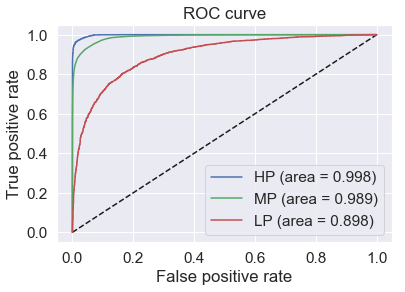

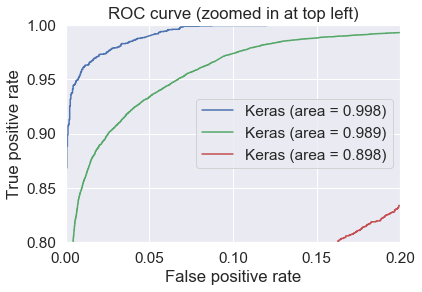

In [58]:
from sklearn.metrics import roc_curve
fpr_keras_HP, tpr_keras_HP, thresholds_keras_HP = roc_curve(y_true_HP[0:len(HP_y_pred)],HP_y_pred)

from sklearn.metrics import auc
auc_keras_HP = auc(fpr_keras_HP, tpr_keras_HP)

from sklearn.metrics import roc_curve
fpr_keras_MP, tpr_keras_MP, thresholds_keras_MP = roc_curve(y_true_MP[0:len(MP_y_pred)],MP_y_pred)

from sklearn.metrics import auc
auc_keras_MP = auc(fpr_keras_MP, tpr_keras_MP)

from sklearn.metrics import roc_curve
fpr_keras_LP, tpr_keras_LP, thresholds_keras_LP = roc_curve(y_true_LP[0:len(LP_y_pred)],LP_y_pred)

from sklearn.metrics import auc
auc_keras_LP = auc(fpr_keras_LP, tpr_keras_LP)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_HP, tpr_keras_HP, label='HP (area = {:.3f})'.format(auc_keras_HP),color='b')
plt.plot(fpr_keras_MP, tpr_keras_MP, label='MP (area = {:.3f})'.format(auc_keras_MP),color='g')
plt.plot(fpr_keras_LP, tpr_keras_LP, label='LP (area = {:.3f})'.format(auc_keras_LP),color='r')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_HP, tpr_keras_HP, label='Keras (area = {:.3f})'.format(auc_keras_HP),color='b')
plt.plot(fpr_keras_MP, tpr_keras_MP, label='Keras (area = {:.3f})'.format(auc_keras_MP),color='g')
plt.plot(fpr_keras_LP, tpr_keras_LP, label='Keras (area = {:.3f})'.format(auc_keras_LP),color='r')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='outputs\\model.png')

[[31015  2494]
 [ 1472 32155]]
number of ellipticals: 33509
number of spirals: 33627


Text(0.5, 1.0, 'MP Confusion Matrix Normalized to Class')

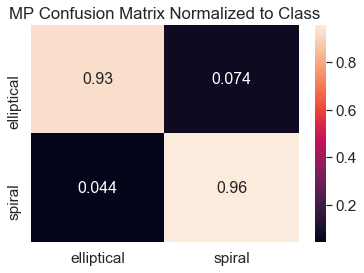

In [49]:
from sklearn.metrics import confusion_matrix
y_pred_keras_test_MP = MP_y_pred 
y_pred_keras_test_MP = np.round(y_pred_keras_test_MP)
cm_out = confusion_matrix(y_true_MP[0:len(MP_y_pred)], y_pred_keras_test_MP)

print(cm_out)

row_0 = cm_out[0,0] + cm_out[0,1]
row_1 = cm_out[1,0] + cm_out[1,1]

print('number of ellipticals:', row_0)
print('number of spirals:', row_1)
cm_out =cm_out.astype(float)
cm_out[0,0] = cm_out[0,0] / row_0
cm_out[0,1] = cm_out[0,1] / row_0
cm_out[1,0] = cm_out[1,0] / row_1
cm_out[1,1] = cm_out[1,1] / row_1

import seaborn as sn
#normal = len(y_pred_keras_test)/2    
df_cm = pd.DataFrame(cm_out, range(2),
                  range(2))
df_cm.columns=['elliptical','spiral']
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},yticklabels=['elliptical','spiral']).set_title("MP Confusion Matrix Normalized to Class")# font size

[[2810   98]
 [  50 2834]]
number of ellipticals: 2908
number of spirals: 2884


Text(0.5, 1.0, 'HP Confusion Matrix Normalized to Class')

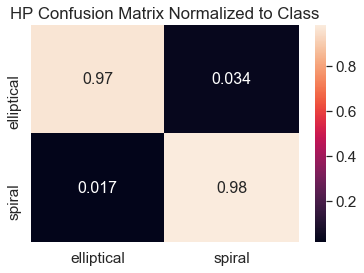

In [57]:
from sklearn.metrics import confusion_matrix
y_pred_keras_test_HP = HP_y_pred 
y_pred_keras_test_HP = np.round(y_pred_keras_test_HP)
cm_out = confusion_matrix(y_true_HP[0:len(HP_y_pred)], y_pred_keras_test_HP)

print(cm_out)

row_0 = cm_out[0,0] + cm_out[0,1]
row_1 = cm_out[1,0] + cm_out[1,1]

print('number of ellipticals:', row_0)
print('number of spirals:', row_1)
cm_out =cm_out.astype(float)
cm_out[0,0] = cm_out[0,0] / row_0
cm_out[0,1] = cm_out[0,1] / row_0
cm_out[1,0] = cm_out[1,0] / row_1
cm_out[1,1] = cm_out[1,1] / row_1

import seaborn as sn
#normal = len(y_pred_keras_test)/2    
df_cm = pd.DataFrame(cm_out, range(2),
                  range(2))
df_cm.columns=['elliptical','spiral']
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},yticklabels=['elliptical','spiral']).set_title("HP Confusion Matrix Normalized to Class")# font size

[[3809  493]
 [ 889 2521]]
number of ellipticals: 4302
number of spirals: 3410


Text(0.5, 1.0, 'LP Confusion Matrix Normalized to Class')

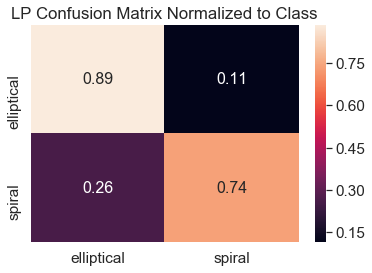

In [52]:
from sklearn.metrics import confusion_matrix
y_pred_keras_test_LP = LP_y_pred 
y_pred_keras_test_LP = np.round(y_pred_keras_test_LP)
cm_out = confusion_matrix(y_true_LP[0:len(LP_y_pred)], y_pred_keras_test_LP)

print(cm_out)

row_0 = cm_out[0,0] + cm_out[0,1]
row_1 = cm_out[1,0] + cm_out[1,1]

print('number of ellipticals:', row_0)
print('number of spirals:', row_1)
cm_out =cm_out.astype(float)
cm_out[0,0] = cm_out[0,0] / row_0
cm_out[0,1] = cm_out[0,1] / row_0
cm_out[1,0] = cm_out[1,0] / row_1
cm_out[1,1] = cm_out[1,1] / row_1

import seaborn as sn
#normal = len(y_pred_keras_test)/2    
df_cm = pd.DataFrame(cm_out, range(2),
                  range(2))
df_cm.columns=['elliptical','spiral']
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},yticklabels=['elliptical','spiral']).set_title("LP Confusion Matrix Normalized to Class")# font size

<h1>Analysis</h1>

In [257]:
#create a second array to use in case we are stupid and overwrite it somehow
HP_y_pred_keras_new = HP_y_pred
LP_y_pred_keras_new = LP_y_pred
MP_y_pred_keras_new = MP_y_pred

In [258]:
#need to append MP data to the above dictionary:

#to do that, we have the objid of our metadata, we have the objid in GZ1 prob, lets create a dictionary of all of the gz1 prob
#by objid, then roll through our metadata to match to the labels.

#first load in the GZ1 catalogue:
"""
HP_LP_prob_Dict = np.load('HP_LP_dict.npy').item()

GZ1_df = pd.read_csv('GalaxyZoo1_DR_table2.csv',usecols=['OBJID','P_CS_DEBIASED','P_EL_DEBIASED'])
middle_dict_spiral = {}
middle_dict_elliptical = {}
for i in range(len(GZ1_df['OBJID'].values)):
    middle_dict_spiral.update({GZ1_df['OBJID'].values[i]:GZ1_df['P_CS_DEBIASED'].values[i]})
    middle_dict_elliptical.update({GZ1_df['OBJID'].values[i]:GZ1_df['P_EL_DEBIASED'].values[i]})
#now use metadata to find labels and add probabilities to the our HP_LP_MP_prob_Dict
k=0
MP_DICT = {}
for DATA in os.listdir('C:\\Users\\awe2\\try_this\\NEW_METADATA\MID_CERTAINTY\\'):
    DF = pd.read_csv('NEW_METADATA\MID_CERTAINTY\\' + DATA, usecols=['objid','target'])
    for i in range(len(DF['objid'].values)):
        string = 'MP_{}'.format(str(k).zfill(5))
        if DF['target'].values[i]==1.0:
            HP_LP_prob_Dict.update({string:middle_dict_spiral[DF['objid'].values[i]]})
        if DF['target'].values[i]==0.0: 
            HP_LP_prob_Dict.update({string:middle_dict_elliptical[DF['objid'].values[i]]})
        k=k+1
        
HP_MP_LP_spiral_prob = HP_LP_prob_Dict
np.save('HP_MP_LP_spiral_prob.npy',HP_MP_LP_spiral_prob)
"""
HP_MP_LP_spiralprob_dict = np.load('HP_MP_LP_spiral_prob.npy').item()

In [261]:
#only run this once or else the ellipticals get all flipped around
HP_GZ1_prob = []
for i,name in enumerate(test_generator.list_IDs):
    HP_GZ1_prob.append(HP_MP_LP_spiralprob_dict[name])
    if test_generator.labels[name] == 0 and i < len(HP_y_pred):
        HP_y_pred_keras_new[i] = 1 - HP_y_pred[i]
        
LP_GZ1_prob = []
for i,name in enumerate(LP_test_generator.list_IDs):
    LP_GZ1_prob.append(HP_MP_LP_spiralprob_dict[name])
    if LP_test_generator.labels[name] == 0 and i < len(LP_y_pred):
        LP_y_pred_keras_new[i] = 1 - LP_y_pred[i]
"""
MP_GZ1_prob = []
for i,name in enumerate(MP_test_generator.list_IDs):
    MP_GZ1_prob.append(HP_MP_LP_spiralprob_dict[name])
    if MP_test_generator.labels[name] == 0 and i < len(MP_y_pred):
        MP_y_pred_keras_new[i] = 1 - MP_y_pred[i]
"""

'\nMP_GZ1_prob = []\nfor i,name in enumerate(MP_test_generator.list_IDs):\n    MP_GZ1_prob.append(HP_MP_LP_spiralprob_dict[name])\n    if MP_test_generator.labels[name] == 0 and i < len(MP_y_pred):\n        MP_y_pred_keras_new[i] = 1 - MP_y_pred[i]\n'

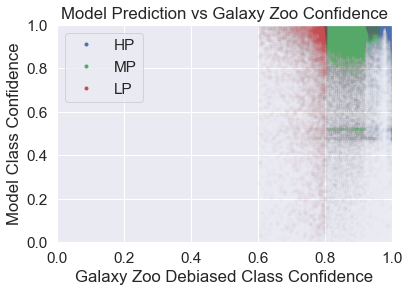

In [267]:
plt.plot(HP_GZ1_prob[0:len(HP_y_pred)],HP_y_pred_keras_new,'b.', alpha=0.01)
plt.plot(MP_GZ1_prob[0:len(MP_y_pred)],MP_y_pred_keras_new,'g.', alpha=0.002)
plt.plot(LP_GZ1_prob[0:len(LP_y_pred)],LP_y_pred_keras_new,'r.', alpha=0.01)

plt.plot(-1,-1,'b.',label='HP')
plt.plot(-1,-1,'g.',label='MP')
plt.plot(-1,-1,'r.',label='LP')


plt.legend()
plt.xlabel('Galaxy Zoo Debiased Class Confidence')
plt.ylabel('Model Class Confidence')
plt.title('Model Prediction vs Galaxy Zoo Confidence')
plt.xlim(0.0,1.0)
plt.ylim(0,1)
plt.show()

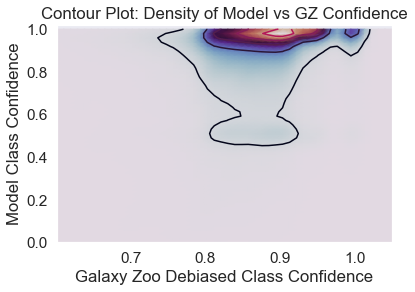

In [300]:
from scipy.stats import kde

y = np.array(HP_GZ1_prob[0:len(HP_y_pred)]+MP_GZ1_prob[0:len(MP_y_pred)]+LP_GZ1_prob[0:len(LP_y_pred)])
x = np.array(HP_y_pred_keras_new[:,0].tolist() + MP_y_pred_keras_new[:,0].tolist() + LP_y_pred_keras_new[:,0].tolist())

nbins=50

k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():1.05:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

#plt.title('2D Histogram')
#plt.hist2d(y, x, bins=nbins, cmap=plt.cm.hot)
#plt.show()

plt.pcolormesh(yi, xi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.twilight)
levels = np.linspace(2,100,10)
plt.contour(yi, xi, zi.reshape(xi.shape), levels=levels)
plt.xlabel('Galaxy Zoo Debiased Class Confidence')
plt.ylabel('Model Class Confidence')
plt.title('Contour Plot: Density of Model vs GZ Confidence')
#plt.xlim(0,1.0)
plt.ylim(0,1.02)
#plt.savefig('Outputs\\Model_prediction_vs_galaxyzoo_confidence_contour.png')
plt.show()


In [ ]:
HP_spiral_histo= []
LP_spiral_histo= []
MP_spiral_histo= []
HP_ellip_histo= []
LP_ellip_histo= []
MP_ellip_histo= []


for i in range(len(HP_y_pred_keras_new)):
    if i < len(HP_y_pred):
        if test_generator.labels[test_generator.list_IDs[i]] == 1:     
            plt.plot(HP_GZ1_prob[i],HP_y_pred_keras_new[i],'b.', alpha=0.1, label='spiral')
            HP_spiral_histo.append(HP_y_pred_keras_new[i])
        if test_generator.labels[test_generator.list_IDs[i]] == 0:
            plt.plot(HP_GZ1_prob[i],HP_y_pred_keras_new[i],'r.', alpha=0.1, label='elliptical')
            HP_ellip_histo.append(HP_y_pred_keras_new[i])

for i in range(len(LP_y_pred_keras_new)):
    if i < len(LP_y_pred):
        if LP_test_generator.labels[LP_test_generator.list_IDs[i]] == 1:     
            plt.plot(LP_GZ1_prob[i],LP_y_pred_keras_new[i],'b.', alpha=0.1, label='spiral')
            LP_spiral_histo.append(LP_y_pred_keras_new[i])
        if LP_test_generator.labels[LP_test_generator.list_IDs[i]] == 0:
            plt.plot(LP_GZ1_prob[i],LP_y_pred_keras_new[i],'r.', alpha=0.1, label='elliptical')
            LP_ellip_histo.append(LP_y_pred_keras_new[i])

for i in range(len(MP_y_pred_keras_new)):
    if i < len(MP_y_pred):
        if MP_test_generator.labels[MP_test_generator.list_IDs[i]] == 1:     
            plt.plot(MP_GZ1_prob[i],MP_y_pred_keras_new[i],'b.', alpha=0.1, label='spiral')
            MP_spiral_histo.append(MP_y_pred_keras_new[i])
        if MP_test_generator.labels[MP_test_generator.list_IDs[i]] == 0:
            plt.plot(MP_GZ1_prob[i],MP_y_pred_keras_new[i],'r.', alpha=0.1, label='elliptical')
            MP_ellip_histo.append(MP_y_pred_keras_new[i])
            
#plt.legend()
plt.xlabel('GZ1 prob')
plt.ylabel('prediction')
plt.title('prediction vs GZ1 prob')
plt.legend()
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

for i,item in enumerate(HP_spiral_histo):
    HP_spiral_histo[i] = item[0]
for i,item in enumerate(HP_ellip_histo):
    HP_ellip_histo[i] = item[0]
for i,item in enumerate(LP_spiral_histo):
    LP_spiral_histo[i] = item[0]
for i,item in enumerate(LP_ellip_histo):
    LP_ellip_histo[i] = item[0]
for i,item in enumerate(MP_spiral_histo):
    MP_spiral_histo[i] = item[0]
for i,item in enumerate(MP_ellip_histo):
    MP_ellip_histo[i] = item[0]

In [ ]:

bins = np.linspace(0.0,1.0,100)
plt.hist(HP_spiral_histo,bins)
plt.title('HP_spirals histogram')
plt.show()

bins = np.linspace(0.95,1.0,40)
plt.hist(HP_spiral_histo,bins)
plt.title('HP_spirals histogram')
plt.show()

bins = np.linspace(0.0,1.0,100)
plt.hist(HP_spiral_histo,bins,cumulative=True,density=True)
plt.title('HP_spirals histogram, cummulative')
plt.show()

In [ ]:
bins = np.linspace(0.0,1.0,100)
plt.hist(HP_ellip_histo,bins,cumulative=True,density=True)
plt.title('HP_ellip histogram, cummulative')
plt.show()

In [ ]:
bins = np.linspace(0.0,1.0,100)
plt.hist(MP_spiral_histo,bins,cumulative=True,density=True)
plt.title('MP Spiral histogram, cummulative')
plt.show()

In [ ]:
bins = np.linspace(0.0,1.0,100)
plt.hist(MP_ellip_histo,bins,cumulative=True,density=True)
plt.title('MP_ellip histogram, cummulative')
plt.show()

In [ ]:
bins = np.linspace(0.0,1.0,100)
plt.hist(LP_spiral_histo,bins,cumulative=True,density=True)
plt.title('LP_spirals histogram, cummulative')
plt.show()

In [ ]:
bins = np.linspace(0.0,1.0,100)
plt.hist(LP_ellip_histo,bins,cumulative=True,density=True)
plt.title('LP_ellip histogram, cummulative')
plt.show()

In [ ]:
"""
LP_Spirals_BAD = []
for i,name in enumerate(LP_test_generator.list_IDs):
    if i < 7840:
        if LP_y_pred_keras_new[i] < 0.1 and LP_test_generator.labels[name] == 1: #spiral with low probability
            LP_Spirals_BAD.append(name)
#print(len(LP_Spirals_BAD)) 1088
#
#Now we have a list of spirals that are hard to classify, we need to analyze this list.
#Essentially, we also have a list of spirals that are easy to classify, those are in mix_list.npy
np.save('LP_Bad_Spirals.npy',np.array(LP_Spirals_BAD))
"""

In [ ]:
plt.plot(HP_GZ1_prob[0:7712],HP_y_pred_keras_new,'b.', alpha=0.3, label='HP')
plt.plot(LP_GZ1_prob[0:7840],LP_y_pred_keras_new,'r.', alpha=0.3, label='LP')
plt.xlabel('GZ1 prob')
plt.ylabel('prediction')
plt.title('prediction vs GZ1 prob')
plt.xlim(0.9,1.01)
plt.ylim(0.2,1.0)
plt.show()

In [253]:
#original mix_list is called mix_list, shouldnt overwrite
"""
mix_list = []
threshold = 0.97
for i in range(len(LP_y_pred_keras_new)):
    if LP_y_pred_keras_new[i] > threshold:
        mix_list.append(LP_test_generator.list_IDs[i])
print(len(mix_list))
np.save('mix_list.npy', np.array(mix_list))
"""
"""
mix_list_MP_new = []
threshold = 0.999158 #gives us exactly the top 10000 performing galaxies in MP
for i in range(len(MP_y_pred_keras_new)):
    if MP_y_pred_keras_new[i] > threshold:
        mix_list_MP_new.append(MP_test_generator.list_IDs[i])
print(len(mix_list_MP_new))
np.save('mix_list_MP_new.npy', np.array(mix_list_MP_new))
"""

10000


<h1>correlate Z and my network outputs</h1>


In [ ]:
#first I need a dictionary of z

In [ ]:
"""
path_HP_Z = 'C:\\Users\\awe2\\try_this\\HP_inputs\\'
path_LP_Z = 'C:\\Users\\awe2\\try_this\\LP_inputs\\'
#we have a system in place to check for used HP, we will make a dictionary that has HP and LP labels and gives z
#dictionary = {'LP_00000':Z}
Z_dict = {}
#while we are here why dont we formalize the setup and make an array of strings to append to our merged_df?
HP_label_array = []
LP_label_array = []

HP_Z_array = merged_df_HP['z'].values
LP_Z_array = merged_df_LP['z_y'].values
for i in range(len(merged_df_HP.index)):
    string = 'HP_' + str(i).zfill(5)+ ".npy"
    HP_label_array.append(string)
    if string in os.listdir(path_HP_Z):
        append_me = {'HP_' + str(i).zfill(5):HP_Z_array[i]}
        Z_dict.update(append_me)
        
for i in range(len(merged_df_LP.index)):
    string = 'LP_' + str(i).zfill(5) + ".npy"
    LP_label_array.append(string)
    if string in os.listdir(path_LP_Z):
        append_me = {'LP_' + str(i).zfill(5):LP_Z_array[i]}
        Z_dict.update(append_me)
"""
"""
f = open("Spectro_Z.txt",'w')
f.write( str(Z_dict) )
f.close()
"""
with open("Z_spectro.txt","r") as inf:
    Z_dict = eval(inf.read())

In [ ]:
#Output on the y-axis and redshift on the x-axis, blue for spirals, red for ellipticals
HP_Z_toplot = []
LP_Z_toplot = []
MP_Z_toplot = []

for i,name in enumerate(test_generator.list_IDs):
    #HP_GZ1_prob.append(HP_LP_prob_Dict[name])
    HP_Z_toplot.append(Z_dict[name])
    #if test_generator.labels[name] == 0 and i < 7712:
    #    HP_y_pred_keras_new[i] = 1 - HP_y_pred[i]
for i,name in enumerate(LP_test_generator.list_IDs):
    #HP_GZ1_prob.append(HP_LP_prob_Dict[name])
    LP_Z_toplot.append(Z_dict[name])
    #if test_generator.labels[name] == 0 and i < 7712:
    #    HP_y_pred_keras_new[i] = 1 - HP_y_pred[i]
for i,name in enumerate(MP_test_generator.list_IDs):
    MP_Z_toplot.append(Z_dict[name])

In [ ]:
#plt.plot(HP_Z_toplot[0:len(HP_y_pred_keras_new)],HP_y_pred_keras_new,'b.',label='HP',alpha=0.3)
plt.plot(LP_Z_toplot[0:len(LP_y_pred_keras_new)],LP_y_pred_keras_new,'r.',label='LP',alpha=0.3)
#plt.legend()
plt.xlim(0,0.25)
plt.xlabel('Redshift Z')
plt.ylabel('network output confidence')
plt.show()

In [ ]:
plt.plot(HP_Z_toplot[0:len(HP_y_pred_keras_new)],HP_y_pred_keras_new,'b.',label='HP',alpha=0.3)
plt.plot(LP_Z_toplot[0:len(LP_y_pred_keras_new)],LP_y_pred_keras_new,'r.',label='LP',alpha=0.3)
plt.legend()
plt.xlim(0,0.4)
plt.xlabel('Redshift Z')
plt.ylabel('network output confidence')
plt.show()

In [ ]:
LP_output_pred = LP_y_pred_keras_new.reshape(7712)
d={'Spectroscopic Redshift':LP_Z_toplot[0:len(LP_y_pred_keras_new)],'Model Output Score':LP_output_pred}
print(np.shape(LP_y_pred_keras_new))
data = pd.DataFrame(data=d)
g=sn.jointplot(x='Spectroscopic Redshift',y='Model Output Score', data=data,color='r',height=10,alpha=0.3,xlim=(0,0.3))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('LP Dataset Spectroscopic Bias') # can also get the figure from plt.gcf()#.set_title('LP Dataset Spectroscopic Bias')

In [ ]:
print(np.shape(HP_y_pred_keras_new))
HP_output_pred = HP_y_pred_keras_new.reshape(7712)
d={'Spectroscopic Redshift':HP_Z_toplot[0:len(HP_y_pred_keras_new)],'Model HP Output Score':HP_output_pred}
data = pd.DataFrame(data=d)
g=sn.jointplot(x='Spectroscopic Redshift',y='Model HP Output Score', data=data,color='b',marginal_kws=dict(bins=100),height=10,alpha=0.3,xlim=(0,0.3))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('HP Dataset Spectroscopic Bias')

In [ ]:
print(np.shape(MP_y_pred_keras_new))
MP_output_pred = MP_y_pred_keras_new.reshape(67136)
d={'Spectroscopic Redshift':MP_Z_toplot[0:len(MP_y_pred_keras_new)],'MP Model Output Probability':MP_output_pred}
data = pd.DataFrame(data=d)
g=sn.jointplot(x='Spectroscopic Redshift',y='MP Model Output Probability', data=data,color='g',height=10,marginal_kws=dict(bins=100),alpha=0.1,xlim=(0,0.3))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('MP Dataset Spectroscopic Bias')

In [ ]:
#now I want to know about the performance of good and bad spirals from LP
good_spiral_Z = []
bad_spiral_Z = []
good_spiral_prob = []
bad_spiral_prob = []
for i in range(len(LP_y_pred_keras_new)):
    if i < 7840:
        if LP_test_generator.labels[LP_test_generator.list_IDs[i]] == 1:     
            if LP_output_pred[i] < 0.2:
                name= LP_test_generator.list_IDs[i]
                bad_spiral_Z.append(Z_dict[name])
                bad_spiral_prob.append(LP_output_pred[i])
            if LP_output_pred[i] > 0.90:
                name= LP_test_generator.list_IDs[i]
                good_spiral_Z.append(Z_dict[name])
                good_spiral_prob.append(LP_output_pred[i])

In [ ]:
plt.plot(good_spiral_Z, good_spiral_prob,'r.', alpha=0.3, label='good')
plt.plot(bad_spiral_Z, bad_spiral_prob,'b.', alpha=0.3, label='bad')
plt.xlim(0,0.25)
plt.title('LP spiral performance')
plt.xlabel('redshift Z')
plt.ylabel('network output probability')
plt.legend()
plt.show()

<h1>3x3 Galaxy Plots</h1>

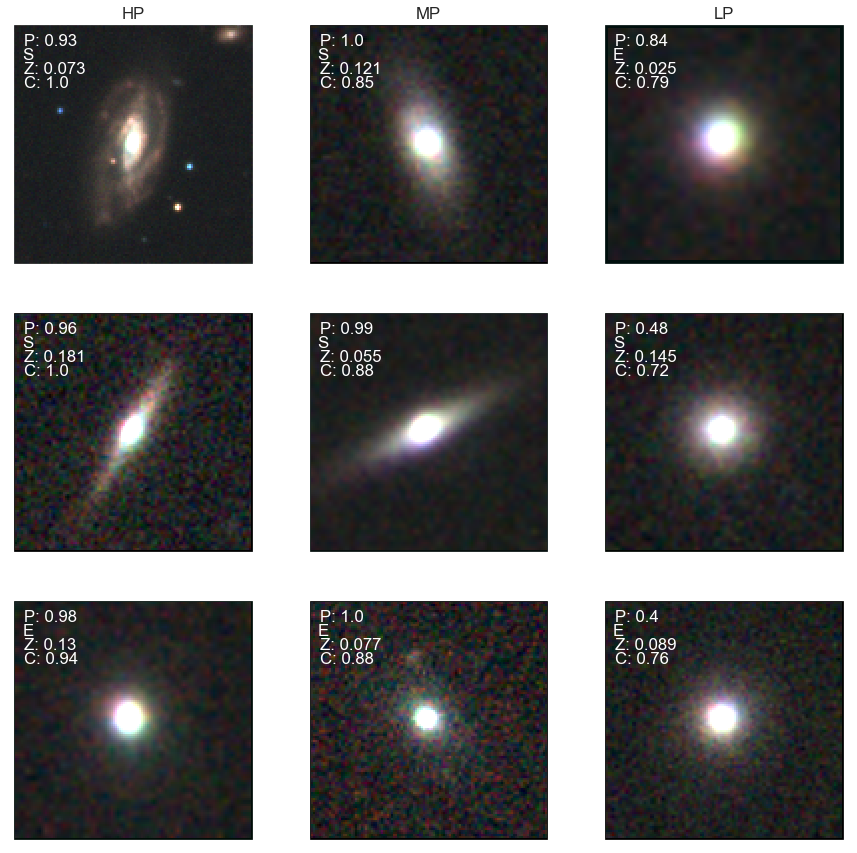

In [368]:
#PLOT THREE GOOD SPIRALS FROM HP,MP,LP, SORT BY DECREASING PROBABILITY, OVERPLOT MODEL OUTPUT AND SPECTRO Z
fig, axs = plt.subplots(3, 3, figsize=(15,15))
start=2
string_dict = {1:'S',0:'E'}
#need some label names
HP_3_by_3_label = test_generator.list_IDs[start:start+3]
MP_3_by_3_label = MP_test_generator.list_IDs[start:start+3]
LP_3_by_3_label = LP_test_generator.list_IDs[start:start+3]
#their output probabilities
HP_3_by_3_output = HP_y_pred_keras_new[start:start+3]
MP_3_by_3_output = MP_y_pred_keras_new[start:start+3]
LP_3_by_3_output = LP_y_pred_keras_new[start:start+3]
#their class targets
HP_3_by_3_target=np.ones(3)
MP_3_by_3_target=np.ones(3)
LP_3_by_3_target=np.ones(3)
for i in range(3):
    HP_3_by_3_target[i] = test_generator.labels[HP_3_by_3_label[i]]
    MP_3_by_3_target[i] = MP_test_generator.labels[MP_3_by_3_label[i]]
    LP_3_by_3_target[i] = LP_test_generator.labels[LP_3_by_3_label[i]]
#their redshifts
HP_3_by_3_Z = HP_Z_toplot[start:start+3]
MP_3_by_3_Z = MP_Z_toplot[start:start+3]
LP_3_by_3_Z = LP_Z_toplot[start:start+3]
#their GZ1 confidence
HP_3_by_3_GZ = HP_GZ1_prob[start:start+3]
MP_3_by_3_GZ = MP_GZ1_prob[start:start+3]
LP_3_by_3_GZ = LP_GZ1_prob[start:start+3]
for i in range(3):
    for j in range(3):
        if i==0:
            img_raw = np.load('HP_inputs\\'+HP_3_by_3_label[j]+'.npy').astype(np.int)
            u = img_raw[:,:,0]
            g = img_raw[:,:,1]
            i_mag = img_raw[:,:,2]
            r = img_raw[:,:,3]
            z = img_raw[:,:,4]
            img = np.empty((120,120,3)).astype(np.int)
            img[:,:,0] = g
            img[:,:,1] = r
            img[:,:,2] = i_mag
            text1=HP_3_by_3_output[j]
            text2=HP_3_by_3_target[j]
            text3=HP_3_by_3_Z[j]
            text4=HP_3_by_3_GZ[j]
        if i==1:
            img = np.load('MP_inputs\\'+MP_3_by_3_label[j]+'.npy').astype(np.int)
            img=img[:,:,1:4]
            text1=MP_3_by_3_output[j]
            text2=MP_3_by_3_target[j]
            text3=MP_3_by_3_Z[j]
            text4=MP_3_by_3_GZ[j]
        if i==2:
            img = np.load('LP_inputs\\'+LP_3_by_3_label[j]+'.npy').astype(np.int)
            img=img[:,:,1:4]
            text1=LP_3_by_3_output[j]
            text2=LP_3_by_3_target[j]
            text3=LP_3_by_3_Z[j]
            text4=LP_3_by_3_GZ[j]
    
        
        axs[j, i].imshow(img)
        axs[j, i].text(x=5,y=10,s='P: ' + str(round(text1[0],2)),color='w')
        axs[j, i].text(x=4,y=17,s= string_dict[text2],color='w')
        axs[j, i].text(x=5,y=24,s='Z: ' + str(round(text3,3)),color='w')
        axs[j, i].text(x=5,y=31,s='C: ' + str(round(text4,2)),color='w')
        # Hide grid lines
        axs[j, i].grid(False)
        if j ==0:
            if i == 0:
                axs[j,i].set_title('HP')
            if i == 1:
                axs[j,i].set_title('MP')
            if i == 2:
                axs[j,i].set_title('LP')
        # Hide axes ticks
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
#plt.savefig('C:\\Users\\awe2\\try_this\\Outputs\\poster_pictures\\morphology_3x3_savefig_new.png')

In [339]:
#Spectro Z vs GZ classification 

HP_Z_end = []
MP_Z_end = []
LP_Z_end = []
HP_C_end = []
MP_C_end = []
LP_C_end = []

for key in Z_dict.keys():
    if key.split('_')[0] == 'HP':
        HP_Z_end.append(Z_dict[key])
        HP_C_end.append(HP_MP_LP_spiralprob_dict[key])
    if key.split('_')[0] == 'MP':
        MP_Z_end.append(Z_dict[key])
        MP_C_end.append(HP_MP_LP_spiralprob_dict[key])
    if key.split('_')[0] == 'LP':
        LP_Z_end.append(Z_dict[key])
        LP_C_end.append(HP_MP_LP_spiralprob_dict[key])

40620

(0.6, 1.0)

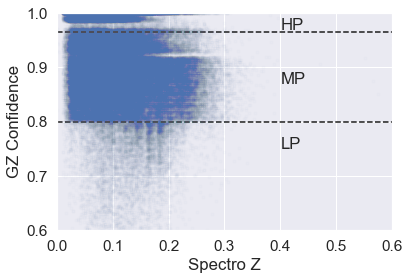

In [315]:
plt.plot(Z_end,GZ_confidence_end,'.',alpha=0.01)
plt.hlines(0.965,0,1,linestyles='dashed')
plt.hlines(0.80,0,1,linestyles='dashed')
plt.text(0.4,0.97,'HP')
plt.text(0.4,0.87,'MP')
plt.text(0.4,0.75,'LP')
plt.xlabel('Spectro Z')
plt.ylabel('GZ Confidence')
plt.xlim(0,0.6)
plt.ylim(0.6,1.0)

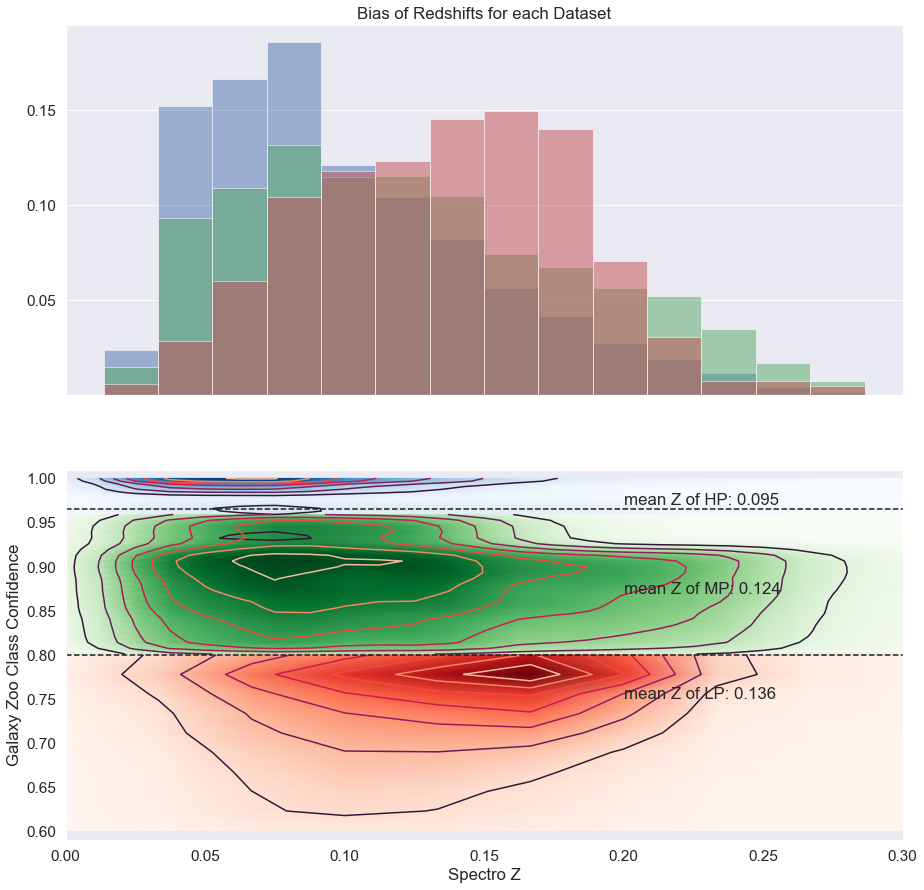

In [367]:
x_HP = np.array(HP_Z_end)
y_HP = np.array(HP_C_end)

nbins=25

k_HP = kde.gaussian_kde([x_HP,y_HP])
xi_HP, yi_HP = np.mgrid[x_HP.min():0.3:nbins*1j, y_HP.min():y_HP.max():nbins*1j]
zi_HP = k_HP(np.vstack([xi_HP.flatten(), yi_HP.flatten()]))
###############
x_MP = np.array(MP_Z_end)
y_MP = np.array(MP_C_end)

nbins=25

k_MP = kde.gaussian_kde([x_MP,y_MP])
xi_MP, yi_MP = np.mgrid[x_MP.min():0.3:nbins*1j, y_MP.min():y_MP.max():nbins*1j]
zi_MP = k_MP(np.vstack([xi_MP.flatten(), yi_MP.flatten()]))
#####################
x_LP = np.array(LP_Z_end)
y_LP = np.array(LP_C_end)

nbins=10

k_LP = kde.gaussian_kde([x_LP,y_LP])
xi_LP, yi_LP = np.mgrid[x_LP.min():0.3:nbins*1j, y_LP.min():y_LP.max():nbins*1j]
zi_LP = k_LP(np.vstack([xi_LP.flatten(), yi_LP.flatten()]))
#plt.title('2D Histogram')
#plt.hist2d(y, x, bins=nbins, cmap=plt.cm.hot)
#plt.show()
f, axs = plt.subplots(2,2,figsize=(15,15),gridspec_kw={'height_ratios': [1, 20]})
plt.subplot(211)
bins = np.linspace(0,0.30,15)
weights = np.ones_like(x_HP)/float(len(x_HP))
plt.hist(x_HP,bins,color='b',weights=weights,alpha=0.5)
weights = np.ones_like(x_MP)/float(len(x_MP))
plt.hist(x_MP,bins,color='g',weights=weights,alpha=0.5)
weights = np.ones_like(x_LP)/float(len(x_LP))
plt.hist(x_LP,bins,color='r',weights=weights,alpha=0.5)
plt.title('Bias of Redshifts for each Dataset')
plt.xticks([])
plt.yticks([0.05,0.10,0.15])
plt.subplot(212)

plt.pcolormesh(xi_HP, yi_HP, zi_HP.reshape(xi_HP.shape), shading='gouraud', cmap=plt.cm.Blues)
#levels = np.linspace(1,10000,10)
plt.contour(xi_HP, yi_HP, zi_HP.reshape(xi_HP.shape))
#########
plt.pcolormesh(xi_MP, yi_MP, zi_MP.reshape(xi_MP.shape), shading='gouraud', cmap=plt.cm.Greens)
#levels = np.linspace(1,10000,10)
plt.contour(xi_MP, yi_MP, zi_MP.reshape(xi_MP.shape))
###########
plt.pcolormesh(xi_LP, yi_LP, zi_LP.reshape(xi_LP.shape), shading='gouraud', cmap=plt.cm.Reds)
#levels = np.linspace(1,10000,10)
plt.contour(xi_LP, yi_LP, zi_LP.reshape(xi_LP.shape))



plt.xlabel('Spectro Z')
plt.ylabel('Galaxy Zoo Class Confidence')

plt.hlines(0.965,0,1,linestyles='dashed')
plt.hlines(0.80,0,1,linestyles='dashed')
plt.text(0.20,0.97,'mean Z of HP: ' + str(round(np.mean(x_HP),3)))
plt.text(0.20,0.87,'mean Z of MP: ' + str(round(np.mean(x_MP),3)))
plt.text(0.20,0.75,'mean Z of LP: ' + str(round(np.mean(x_LP),3)))
plt.xlim(0,0.3)
plt.ylim(0.59,1.01)
plt.savefig('Outputs\\Bias_of_redshifts.png')
plt.show()

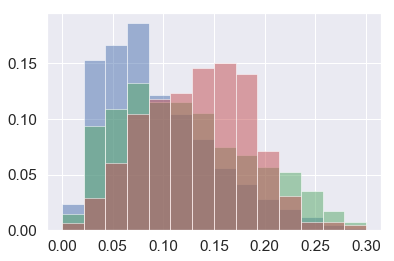